In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import cv2
from skimage.transform import resize
from skimage.io import imread
from sklearn.utils import shuffle
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm



import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Categories=['glioma','meningioma','notumor','pituitary']
train = '/content/drive/My Drive/brain_tumor_4class/Training'
test = '/content/drive/My Drive/brain_tumor_4class/Testing'


flat_data_arr=[] #input array
target_arr=[] #output array
for i in Categories:
    path=os.path.join(train,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(32,32,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target
x_train=df.iloc[:,:-1] #input data
y_train=df.iloc[:,-1] #output data
x_train=x_train.sample(frac=1, random_state=42).reset_index(drop=True)
y_train=y_train.sample(frac=1, random_state=42).reset_index(drop=True)

loaded category:glioma successfully
loaded category:meningioma successfully
loaded category:notumor successfully
loaded category:pituitary successfully


# Reading Test

In [4]:
flat_data_arr_2=[] #input array
target_arr_2=[] #output array
for i in Categories:
    path=os.path.join(test,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(32,32,3))
        flat_data_arr_2.append(img_resized.flatten())
        target_arr_2.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data_2=np.array(flat_data_arr_2)
target_2=np.array(target_arr_2)
df2=pd.DataFrame(flat_data_2) #dataframe
df2['Target']=target_2
x_test=df2.iloc[:,:-1] #input data
y_test=df2.iloc[:,-1] #output data
x_test=x_test.sample(frac=1, random_state=42).reset_index(drop=True)
y_test=y_test.sample(frac=1, random_state=42).reset_index(drop=True)

loaded category:glioma successfully
loaded category:meningioma successfully
loaded category:notumor successfully
loaded category:pituitary successfully


# Visualization

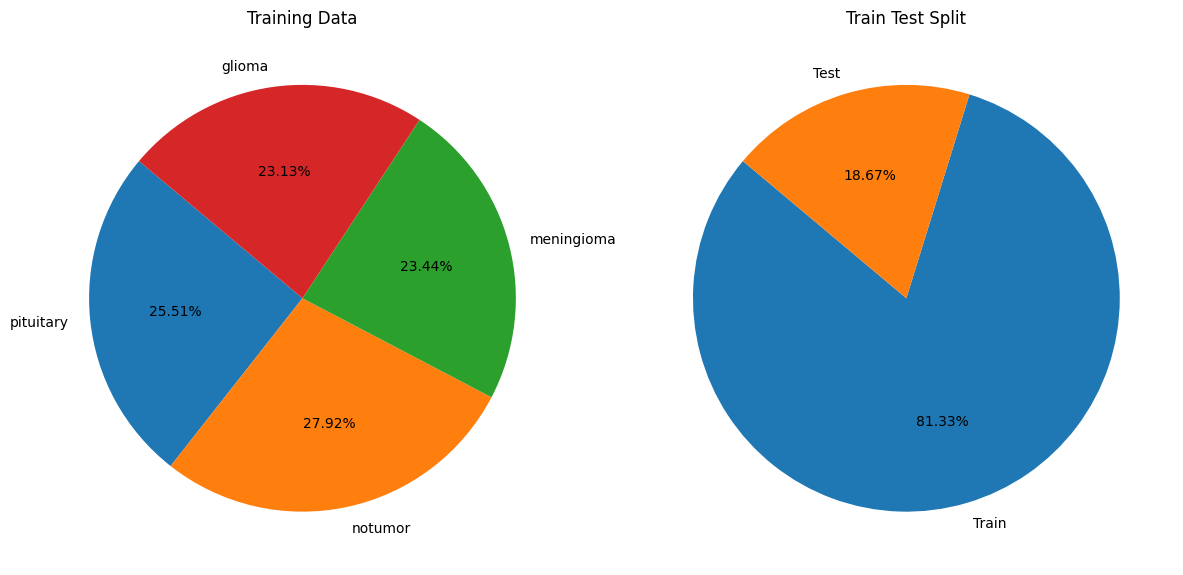

In [ ]:
import matplotlib.pyplot as plt

# Sample data for training and testing counts
training_counts = {'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}
testing_counts = {'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}

# Extract the labels and counts for the pie charts
labels = list(training_counts.keys())
training_sizes = list(training_counts.values())
testing_sizes = list(testing_counts.values())

# Calculate total counts for train and test to calculate percentages for the split pie chart
total_train = sum(training_sizes)
total_test = sum(testing_sizes)
train_test_sizes = [total_train, total_test]

# Create a pie chart for training data
plt.figure(figsize=(12, 6))

# First pie chart for training data
plt.subplot(1, 2, 1)
plt.pie(training_sizes, labels=labels, autopct='%1.2f%%', startangle=140)
plt.title('Training Data')

# Second pie chart for train-test split
plt.subplot(1, 2, 2)
plt.pie(train_test_sizes, labels=['Train', 'Test'], autopct='%1.2f%%', startangle=140)
plt.title('Train Test Split')

# Show the pie charts
plt.tight_layout()
plt.show()

In [7]:
x_train

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.006717,0.006717,0.006717,0.006691,0.006691,0.006691,7.125746e-03,7.125746e-03,7.125746e-03,8.010331e-03,...,0.213951,0.243917,0.243917,0.243917,0.154377,0.154377,0.154377,0.031856,0.031856,0.031856
1,0.055666,0.055666,0.055666,0.035140,0.035140,0.035140,3.498613e-02,3.498613e-02,3.498613e-02,3.624319e-02,...,0.046844,0.045970,0.045970,0.045970,0.043167,0.043167,0.043167,0.041633,0.041633,0.041633
2,0.008416,0.008416,0.008416,0.010489,0.010489,0.010489,1.176811e-02,1.176811e-02,1.176811e-02,1.211533e-02,...,0.008175,0.007898,0.007898,0.007898,0.007921,0.007921,0.007921,0.007922,0.007922,0.007922
3,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,1.176471e-02,1.176471e-02,1.176471e-02,1.176471e-02,...,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765,0.011765
4,0.000003,0.000003,0.000003,0.000601,0.000601,0.000601,4.107928e-03,4.107928e-03,4.107928e-03,5.884886e-03,...,0.005911,0.005319,0.005319,0.005319,0.001007,0.001007,0.001007,0.000005,0.000005,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5903,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,3.921569e-03,3.921569e-03,3.921569e-03,3.921569e-03,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
5904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.035702e-10,8.035702e-10,8.035702e-10,1.809447e-06,...,0.001380,0.000020,0.000020,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5905,0.000013,0.000013,0.000013,0.000155,0.000155,0.000155,2.731511e-04,2.731511e-04,2.731511e-04,3.683302e-04,...,0.008052,0.007445,0.007445,0.007445,0.006125,0.006125,0.006125,0.000981,0.000981,0.000981
5906,0.013554,0.013554,0.013554,0.014001,0.014001,0.014001,1.553002e-02,1.553002e-02,1.553002e-02,1.607100e-02,...,0.013690,0.010877,0.010877,0.010877,0.012821,0.012821,0.012821,0.008432,0.008432,0.008432


In [8]:
x_test

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.018678,0.018678,0.018678,0.020077,0.020077,0.020077,1.989620e-02,1.989620e-02,1.989620e-02,2.095615e-02,...,0.020746,1.818882e-02,1.818882e-02,1.818882e-02,1.769172e-02,1.769172e-02,1.769172e-02,0.015848,0.015848,0.015848
1,0.006678,0.006678,0.006678,0.006916,0.006916,0.006916,8.030234e-03,8.030234e-03,8.030234e-03,9.418206e-03,...,0.085559,1.236235e-02,1.236235e-02,1.236235e-02,8.565284e-03,8.565284e-03,8.565284e-03,0.006937,0.006937,0.006937
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.196850e-08,...,0.000023,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
3,0.003403,0.003403,0.003403,0.003818,0.003818,0.003818,4.256437e-03,4.256437e-03,4.256437e-03,5.682928e-03,...,0.003380,3.277777e-03,3.277777e-03,3.277777e-03,3.269288e-03,3.269288e-03,3.269288e-03,0.002469,0.002469,0.002469
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.345723e-08,4.345723e-08,4.345723e-08,9.185091e-06,...,0.000150,4.546220e-07,4.546220e-07,4.546220e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.542918e-06,1.542918e-06,1.542918e-06,4.721370e-05,...,0.000959,7.114110e-05,7.114110e-05,7.114110e-05,9.730891e-08,9.730891e-08,9.730891e-08,0.000000,0.000000,0.000000
1307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.338374e-08,2.338374e-08,2.338374e-08,2.284029e-05,...,0.000619,2.883832e-06,2.883832e-06,2.883832e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
1308,0.016476,0.016476,0.016476,0.018454,0.018454,0.018454,2.034843e-02,2.034843e-02,2.034843e-02,1.758951e-02,...,0.059274,6.318477e-02,6.318477e-02,6.318477e-02,7.351988e-02,7.351988e-02,7.351988e-02,0.064646,0.064646,0.064646
1309,0.003745,0.003745,0.003745,0.003520,0.003520,0.003520,3.291101e-03,3.291101e-03,3.291101e-03,7.063288e-03,...,0.007777,5.685201e-03,5.685201e-03,5.685201e-03,3.709512e-03,3.709512e-03,3.709512e-03,0.003565,0.003565,0.003565


In [5]:
def test_score(trained_model):
    pred_y = trained_model.predict(x_test)
    print(confusion_matrix(y_test,pred_y))
    print(classification_report(y_test,pred_y))

def train_score(trained_model):
    pred_y = trained_model.predict(x_train)
    print(confusion_matrix(y_train,pred_y))
    print(classification_report(y_train,pred_y))

def test_score_pca(trained_model):
    pred_y = trained_model.predict(x_test_pca)
    print(confusion_matrix(y_test,pred_y))
    print(classification_report(y_test,pred_y))

def train_score_pca(trained_model):
    pred_y = trained_model.predict(x_train_pca)
    print(confusion_matrix(y_train,pred_y))
    print(classification_report(y_train,pred_y))

# PCA



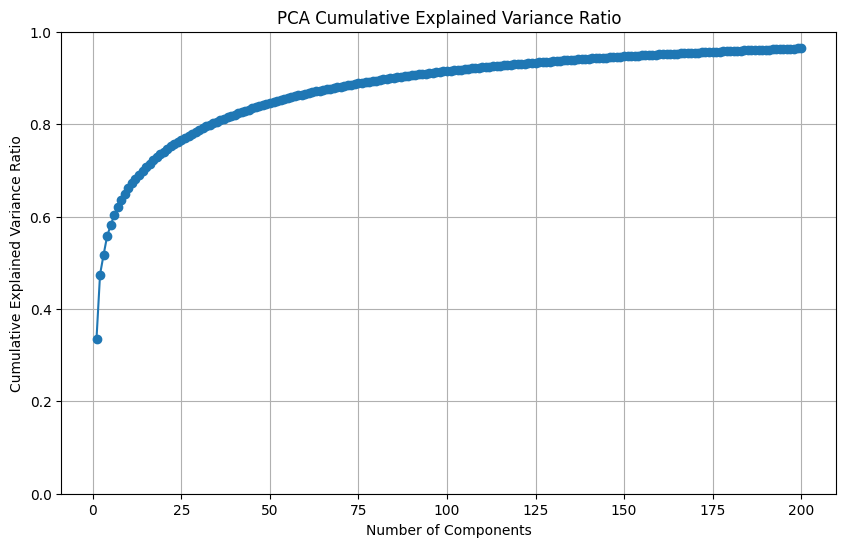

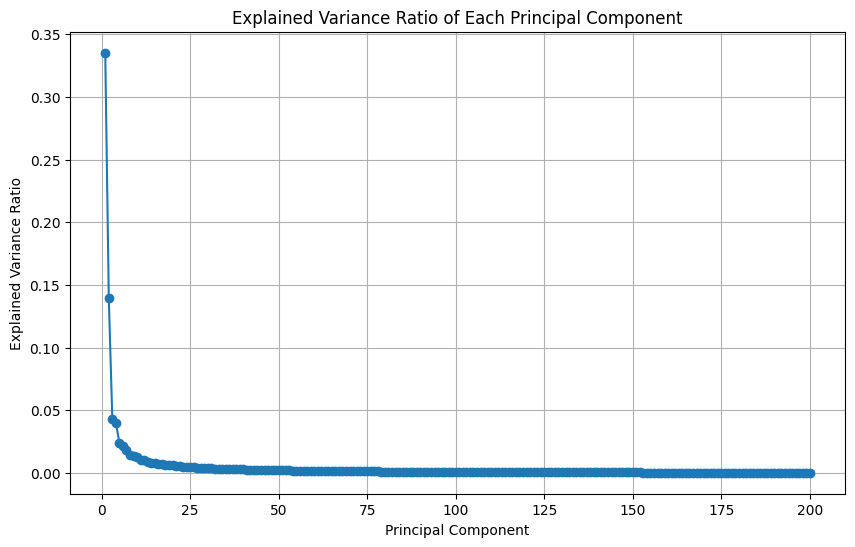

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
x_train_pca = pca.fit_transform(x_train)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance Ratio')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.grid(True)
plt.show()

x_test_pca = pca.fit_transform(x_test)

In [7]:
cumulative_explained_variance_ratio[-1]

0.9640510016942797

# SVM basic and grid search with no PCA

---



In [12]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid={'C':[0.1,1,10],'kernel':['rbf','poly', 'linear']}
model=GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
model.fit(x_train, y_train)

print(model.best_params_)

# 29 minute

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.785 total time= 1.1min
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.764 total time= 1.1min
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.772 total time= 1.1min
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.766 total time= 1.1min
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.759 total time= 1.1min
[CV 1/5] END ................C=0.1, kernel=poly;, score=0.829 total time=  47.4s
[CV 2/5] END ................C=0.1, kernel=poly;, score=0.813 total time=  48.1s
[CV 3/5] END ................C=0.1, kernel=poly;, score=0.792 total time=  46.7s
[CV 4/5] END ................C=0.1, kernel=poly;, score=0.808 total time=  46.3s
[CV 5/5] END ................C=0.1, kernel=poly;, score=0.802 total time=  48.2s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.880 total time=  33.3s
[CV 2/5] END ..............C=0.1, kernel=linear;,

In [13]:
print(model.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [14]:
best_train_model = svm.SVC(C=10, kernel = 'rbf').fit(x_train, y_train)

In [15]:
train_score(best_train_model)
test_score(best_train_model)

[[1295   25    0    1]
 [  24 1507    2    2]
 [   2    5 1588    0]
 [   0    2    0 1455]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1321
           1       0.98      0.98      0.98      1535
           2       1.00      1.00      1.00      1595
           3       1.00      1.00      1.00      1457

    accuracy                           0.99      5908
   macro avg       0.99      0.99      0.99      5908
weighted avg       0.99      0.99      0.99      5908

[[272  26   0   2]
 [ 18 279   7   2]
 [  0   4 401   0]
 [  0   1   0 299]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       300
           1       0.90      0.91      0.91       306
           2       0.98      0.99      0.99       405
           3       0.99      1.00      0.99       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg   

# SVM - PCA

In [16]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid={'C':[0.1,1,10],'kernel':['rbf','poly', 'linear']}
model=GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
model.fit(x_train_pca, y_train)

print(model.best_params_)

# 3 minute

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.806 total time=   4.6s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.796 total time=   4.0s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.799 total time=   3.5s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.808 total time=   3.4s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.792 total time=   5.6s
[CV 1/5] END ................C=0.1, kernel=poly;, score=0.676 total time=   4.9s
[CV 2/5] END ................C=0.1, kernel=poly;, score=0.663 total time=   3.4s
[CV 3/5] END ................C=0.1, kernel=poly;, score=0.681 total time=   3.4s
[CV 4/5] END ................C=0.1, kernel=poly;, score=0.638 total time=   4.2s
[CV 5/5] END ................C=0.1, kernel=poly;, score=0.638 total time=   4.2s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.868 total time=   1.6s
[CV 2/5] END ..............C=0.1, kernel=linear;,

In [17]:
best_train_model = svm.SVC(C=10, kernel = 'rbf').fit(x_train_pca, y_train)

In [18]:
train_score_pca(best_train_model)
test_score_pca(best_train_model)

[[1311   10    0    0]
 [   9 1524    0    2]
 [   1    0 1594    0]
 [   0    2    0 1455]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1321
           1       0.99      0.99      0.99      1535
           2       1.00      1.00      1.00      1595
           3       1.00      1.00      1.00      1457

    accuracy                           1.00      5908
   macro avg       1.00      1.00      1.00      5908
weighted avg       1.00      1.00      1.00      5908

[[175  83  28  14]
 [ 61 135  95  15]
 [ 37  85 263  20]
 [ 31  50 137  82]]
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       300
           1       0.38      0.44      0.41       306
           2       0.50      0.65      0.57       405
           3       0.63      0.27      0.38       300

    accuracy                           0.50      1311
   macro avg       0.52      0.49      0.48      1311
weighted avg   

# Penalized Logistic Regression & GridSearch

In [19]:
from sklearn.linear_model import LogisticRegression


param_grid={'penalty':['none','l1','l2','elasticnet'],'solver':['liblinear','newton-cholesky','sag', 'saga'],'multi_class':['auto']}
model=GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=3)
model.fit(x_train, y_train)

print(model.best_params_)

# 46 minute

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.1s
[CV 2/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.1s
[CV 3/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.1s
[CV 4/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.1s
[CV 5/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.1s
[CV 1/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, score=nan total time=  15.5s
[CV 2/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, score=0.853 total time=  31.5s
[CV 3/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, score=0.833 total time=  31.9s
[CV 4/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, score=nan total time=  46.1s
[CV 5/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, scor

In [20]:
best_train_model = LogisticRegression(multi_class='auto', penalty='l2', solver='newton-cholesky').fit(x_train, y_train)

In [21]:
train_score(best_train_model)
test_score(best_train_model)

[[1176  131    4   10]
 [ 111 1271   74   79]
 [  24   24 1534   13]
 [  12   23    3 1419]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1321
           1       0.88      0.83      0.85      1535
           2       0.95      0.96      0.96      1595
           3       0.93      0.97      0.95      1457

    accuracy                           0.91      5908
   macro avg       0.91      0.91      0.91      5908
weighted avg       0.91      0.91      0.91      5908

[[235  53   3   9]
 [ 34 205  44  23]
 [  7  11 385   2]
 [  4  11   2 283]]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       300
           1       0.73      0.67      0.70       306
           2       0.89      0.95      0.92       405
           3       0.89      0.94      0.92       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg   

# Penalized Logistic Regression & PCA


In [22]:
from sklearn.linear_model import LogisticRegression


param_grid={'penalty':['none','l1','l2','elasticnet'],'solver':['liblinear','newton-cholesky','sag', 'saga'],'multi_class':['auto']}
model=GridSearchCV(LogisticRegression(),param_grid,refit=True,verbose=3)
model.fit(x_train_pca, y_train)

print(model.best_params_)

# 2 minute

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END multi_class=auto, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, score=0.847 total time=   0.9s
[CV 2/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, score=0.821 total time=   0.8s
[CV 3/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, score=0.805 total time=   0.9s
[CV 4/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, score=0.821 total time=   0.8s
[CV 5/5] END multi_class=auto, penalty=none, solver=newton-cholesky;, 

In [23]:
best_train_model = LogisticRegression(multi_class='auto', penalty='l2', solver='newton-cholesky').fit(x_train_pca, y_train)

In [24]:
train_score_pca(best_train_model)
test_score_pca(best_train_model)

[[1126  164   13   18]
 [ 182 1098  113  142]
 [  42   56 1465   32]
 [  21   53   11 1372]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1321
           1       0.80      0.72      0.76      1535
           2       0.91      0.92      0.92      1595
           3       0.88      0.94      0.91      1457

    accuracy                           0.86      5908
   macro avg       0.85      0.86      0.85      5908
weighted avg       0.85      0.86      0.85      5908

[[174  72  30  24]
 [ 64 118  75  49]
 [ 53  64 221  67]
 [ 19  45  99 137]]
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       300
           1       0.39      0.39      0.39       306
           2       0.52      0.55      0.53       405
           3       0.49      0.46      0.47       300

    accuracy                           0.50      1311
   macro avg       0.49      0.49      0.49      1311
weighted avg   

# Random Forest and GridSearch

In [8]:
from sklearn.ensemble import RandomForestClassifier


param_grid={'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] }
model=GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=3)
model.fit(x_train, y_train)

print(model.best_params_)

#2h10 minute

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.947 total time=  17.4s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.928 total time=  16.3s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.927 total time=  16.3s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.931 total time=  16.3s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.938 total time=  16.3s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.939 total time=  34.1s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.928 total time=  31.8s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.927 to

In [16]:
from sklearn.ensemble import RandomForestClassifier

best_train_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5,n_estimators = 100).fit(x_train, y_train)

In [17]:
train_score(best_train_model)
test_score(best_train_model)

[[1321    0    0    0]
 [   0 1534    0    1]
 [   0    0 1595    0]
 [   0    0    0 1457]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1535
           2       1.00      1.00      1.00      1595
           3       1.00      1.00      1.00      1457

    accuracy                           1.00      5908
   macro avg       1.00      1.00      1.00      5908
weighted avg       1.00      1.00      1.00      5908

[[253  42   0   5]
 [ 11 282   9   4]
 [  0   0 405   0]
 [  0   5   1 294]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       300
           1       0.86      0.92      0.89       306
           2       0.98      1.00      0.99       405
           3       0.97      0.98      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg   

# Random Forest & PCA

In [12]:
from sklearn.ensemble import RandomForestClassifier


param_grid={'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] }
model=GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=3)
model.fit(x_train_pca, y_train)

print(model.best_params_)

# 41min

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.890 total time=   8.8s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.895 total time=   5.1s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.898 total time=   4.0s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.892 total time=   5.4s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.898 total time=   4.1s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.898 total time=   9.4s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.891 total time=   8.0s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.903 to

In [13]:
from sklearn.ensemble import RandomForestClassifier

best_train_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2,n_estimators = 150).fit(x_train_pca, y_train)

In [14]:
train_score_pca(best_train_model)
test_score_pca(best_train_model)

[[1321    0    0    0]
 [   0 1535    0    0]
 [   0    0 1595    0]
 [   0    0    0 1457]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1535
           2       1.00      1.00      1.00      1595
           3       1.00      1.00      1.00      1457

    accuracy                           1.00      5908
   macro avg       1.00      1.00      1.00      5908
weighted avg       1.00      1.00      1.00      5908

[[176  91  11  22]
 [ 46 135  98  27]
 [ 46  81 245  33]
 [ 31  40  34 195]]
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       300
           1       0.39      0.44      0.41       306
           2       0.63      0.60      0.62       405
           3       0.70      0.65      0.68       300

    accuracy                           0.57      1311
   macro avg       0.58      0.57      0.57      1311
weighted avg   